# **1. Setting environment**

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols

from rdkit.Avalon import pyAvalonTools as fpAvalon
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.optimize import linprog
from sklearn import manifold
import warnings
import sys

# **2. Prepare Data**

We first upload our screening dataset, which consists of two columns: ID and SMILES

In [26]:
#Upload the screening dataset
df_screen = pd.read_csv("data_example.csv")
df_screen

,ID,Canomicalsmiles
0,T1,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...
1,T2,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...
2,T3,CCCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc...
3,T4,CCc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc1...
4,T5,C#Cc1cc2c(=O)c3c4ccc(C#N)cc4[nH]c3n(C(C)C)c2cc...
...,...,...
494,T662,O=C(O)C(F)(F)F.Oc1ccc2cc1Nc1nc(ncc1Cl)Nc1cccc(...
495,T663,Clc1cnc2nc1Nc1cccc(c1)OCCc1cccc(c1)N2.O=C(O)C(...
496,T664,Clc1cnc2nc1Nc1cccc(c1)OCCNc1cccc(c1)N2.O=C(O)C...
497,T668,CN1CCN(c2ccc3cc2/C=C\c2cccc(c2)Nc2nc(ncc2Cl)N3...


## **2.1. Featurizing dataset**

he dataset is featurized using specific molecular representation algorithms. In this case, the SMILE extended connectivity fingerprint (secfp) is implemented. Additionally, a standardization step is performed, which includes cleaning erroneous SMILES or compounds that violate the Rule of Five Lipinski (Ro5).

In [41]:
from data_featurizing import preprocess

pip_process = preprocess(data = df_screen, ro5 = 3)
pip_process.fit()
df_test_ad = pip_process.secfp_ad

STANDARDIZING MOLECULES...


  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

CALCULATING SECFP FINGERPRINTS...


  0%|          | 0/499 [00:00<?, ?it/s]

FINISH CALCULATING!


In [5]:
df_test_ad.head(5)

,ID,Molecule,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,T1,<rdkit.Chem.rdchem.Mol object at 0x1699da810>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,T2,<rdkit.Chem.rdchem.Mol object at 0x1699da7a0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,T3,<rdkit.Chem.rdchem.Mol object at 0x1699da730>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T4,<rdkit.Chem.rdchem.Mol object at 0x1699da650>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T5,<rdkit.Chem.rdchem.Mol object at 0x1699da5e0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **3. PCA+Convex Hull**

In the first approach, molecular fingerprints undergo direct dimension reduction through **principal component analysis (PCA)**, resulting in a 2-dimensional representation. Subsequently, these observations are visualized on a plane, and a **Convex hull** is applied to delineate the confidence region.

In [6]:
from preprocessing import prepare_dataset
from pca_convexhull import PCA_convexhull
from pca_confelip import PCA_conf_elip


In [7]:
#Loading training dataset.
df_train_ad = pd.read_csv("./data_train_ad.csv",index_col = 0)
df_train_ad.drop(['Canomicalsmiles',"pChEMBL"],axis = 1, inplace = True)
df_train_ad

,ID,Molecule,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,C0,<rdkit.Chem.rdchem.Mol object at 0x7f8e5115ff30>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,C1,<rdkit.Chem.rdchem.Mol object at 0x7f8e511f4e10>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C2,<rdkit.Chem.rdchem.Mol object at 0x7f8e511f45d0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C3,<rdkit.Chem.rdchem.Mol object at 0x7f8e511f4e70>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C4,<rdkit.Chem.rdchem.Mol object at 0x7f8e511f4b70>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1659,C2158,<rdkit.Chem.rdchem.Mol object at 0x7f8e514f9990>,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1660,C2164,<rdkit.Chem.rdchem.Mol object at 0x7f8e514f90f0>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1661,C2169,<rdkit.Chem.rdchem.Mol object at 0x7f8e514f9f90>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1662,C2171,<rdkit.Chem.rdchem.Mol object at 0x7f8e514f9870>,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


All predicted molecules are in model's application domain


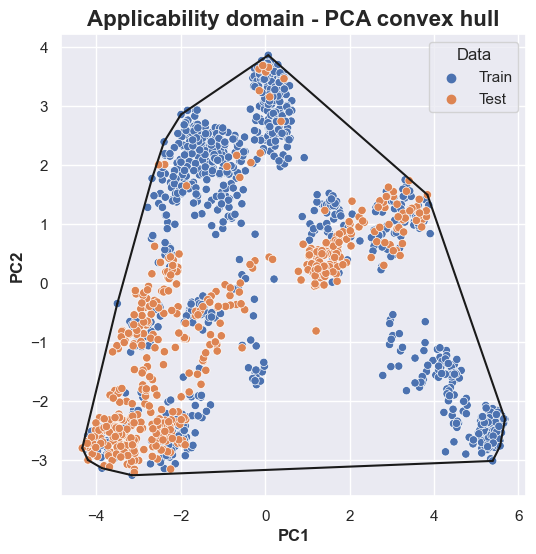

In [8]:
process = prepare_dataset(data_train=df_train_ad, data_test=df_test_ad)
process.fit()
convex = PCA_convexhull(data =process.df_pca, Type = 'Data', figsize = (6,6), savefig=True)
convex.convexhull_fit()

#Defining out molecules
index_pca_convex_out = convex.index_out
if len(index_pca_convex_out) == 0:
    print("All predicted molecules are in model's application domain")
else:
    print(f"There are {len(index_pca_convex_out)} molecules being out out application domain")

# **4. Similarity matrix + MDS + Convex hull**

In the second approach, we initiate the process by calculating **a Tanimoto similarity matrix**, pairing molecules from both the training dataset (m molecules) and screening dataset (n molecules). This results in a (m+n) x (m+n) matrix. Following this, dimension reduction to 2 dimensions is applied to the matrix by **MDS** algorithms. The resulting observations are then plotted on a plane. Similar to the first approach, a **Convex hull** is employed to delineate the confident region

## **4.1. Calculating similarity matrix**

In [9]:
from similarity_matrix import similarity_matrix
simi = similarity_matrix(data_train=df_train_ad, data_test=df_test_ad)
simi.fit()

In [22]:
simi.matrix

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,T645,T648,T653,T656,T658,T662,T663,T664,T668,T669
C0,1.000000,0.714286,0.808989,0.712766,0.614583,0.670213,0.537736,0.438596,0.109677,0.580000,...,0.062937,0.062069,0.444444,0.048611,0.049645,0.071429,0.056338,0.040816,0.106061,0.062937
C1,0.714286,1.000000,0.747475,0.712871,0.546296,0.656863,0.521739,0.466667,0.121951,0.603774,...,0.058065,0.064103,0.460870,0.038217,0.066667,0.058824,0.045161,0.037736,0.112676,0.064935
C2,0.808989,0.747475,1.000000,0.729167,0.553398,0.687500,0.527273,0.432203,0.120253,0.567308,...,0.060811,0.067114,0.463636,0.046980,0.055172,0.068966,0.054422,0.039474,0.118519,0.060811
C3,0.712766,0.712871,0.729167,1.000000,0.523810,0.780220,0.500000,0.482456,0.164474,0.582524,...,0.068027,0.074324,0.533333,0.046980,0.069930,0.068966,0.054422,0.039474,0.161538,0.068027
C4,0.614583,0.546296,0.553398,0.523810,1.000000,0.514563,0.780220,0.495413,0.049080,0.825581,...,0.055944,0.055172,0.371681,0.048951,0.050000,0.064286,0.049296,0.034014,0.043165,0.055944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T662,0.071429,0.058824,0.068966,0.068966,0.064286,0.055944,0.068027,0.067568,0.328000,0.070423,...,0.351852,0.480000,0.056338,0.593407,0.183333,1.000000,0.636364,0.470000,0.372549,0.569892
T663,0.056338,0.045161,0.054422,0.054422,0.049296,0.041379,0.068027,0.039474,0.267176,0.048276,...,0.417476,0.465347,0.041667,0.611111,0.203390,0.636364,1.000000,0.651685,0.386139,0.569892
T664,0.040816,0.037736,0.039474,0.039474,0.034014,0.033557,0.045752,0.038710,0.224638,0.033333,...,0.295652,0.360360,0.033784,0.465347,0.208333,0.470000,0.651685,1.000000,0.324074,0.602151
T668,0.106061,0.112676,0.118519,0.161538,0.043165,0.157480,0.047945,0.076923,0.384615,0.080292,...,0.302752,0.398058,0.140625,0.396040,0.179487,0.372549,0.386139,0.324074,1.000000,0.405941


## **4.2. MDS+Convex Hull**

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,T645,T648,T653,T656,T658,T662,T663,T664,T668,T669


,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,T645,T648,T653,T656,T658,T662,T663,T664,T668,T669
T5,0.670213,0.656863,0.687500,0.780220,0.514563,1.000000,0.504587,0.486486,0.145695,0.574257,...,0.047945,0.054422,0.554455,0.034014,0.049296,0.055944,0.041379,0.033557,0.157480,0.055172
T275,0.066667,0.048780,0.050955,0.057692,0.039216,0.052288,0.037267,0.076923,0.333333,0.038462,...,0.228346,0.274194,0.095890,0.250000,0.369369,0.262295,0.272727,0.276423,0.260504,0.258065
T306,0.078431,0.106250,0.103896,0.133333,0.037975,0.129252,0.042424,0.108974,0.436508,0.070513,...,0.192593,0.253846,0.178571,0.240310,0.353448,0.251969,0.242188,0.246154,0.359649,0.248062
T413,0.837209,0.808511,0.852273,0.852273,0.570000,0.806818,0.542056,0.482143,0.160000,0.632653,...,0.054795,0.061224,0.549020,0.040816,0.048951,0.062937,0.048276,0.033333,0.156250,0.054795
T421,0.578431,0.587156,0.596154,0.676768,0.467890,0.687500,0.448276,0.495575,0.141935,0.523364,...,0.046667,0.060000,0.677083,0.033113,0.047945,0.054422,0.040268,0.032680,0.135338,0.053691


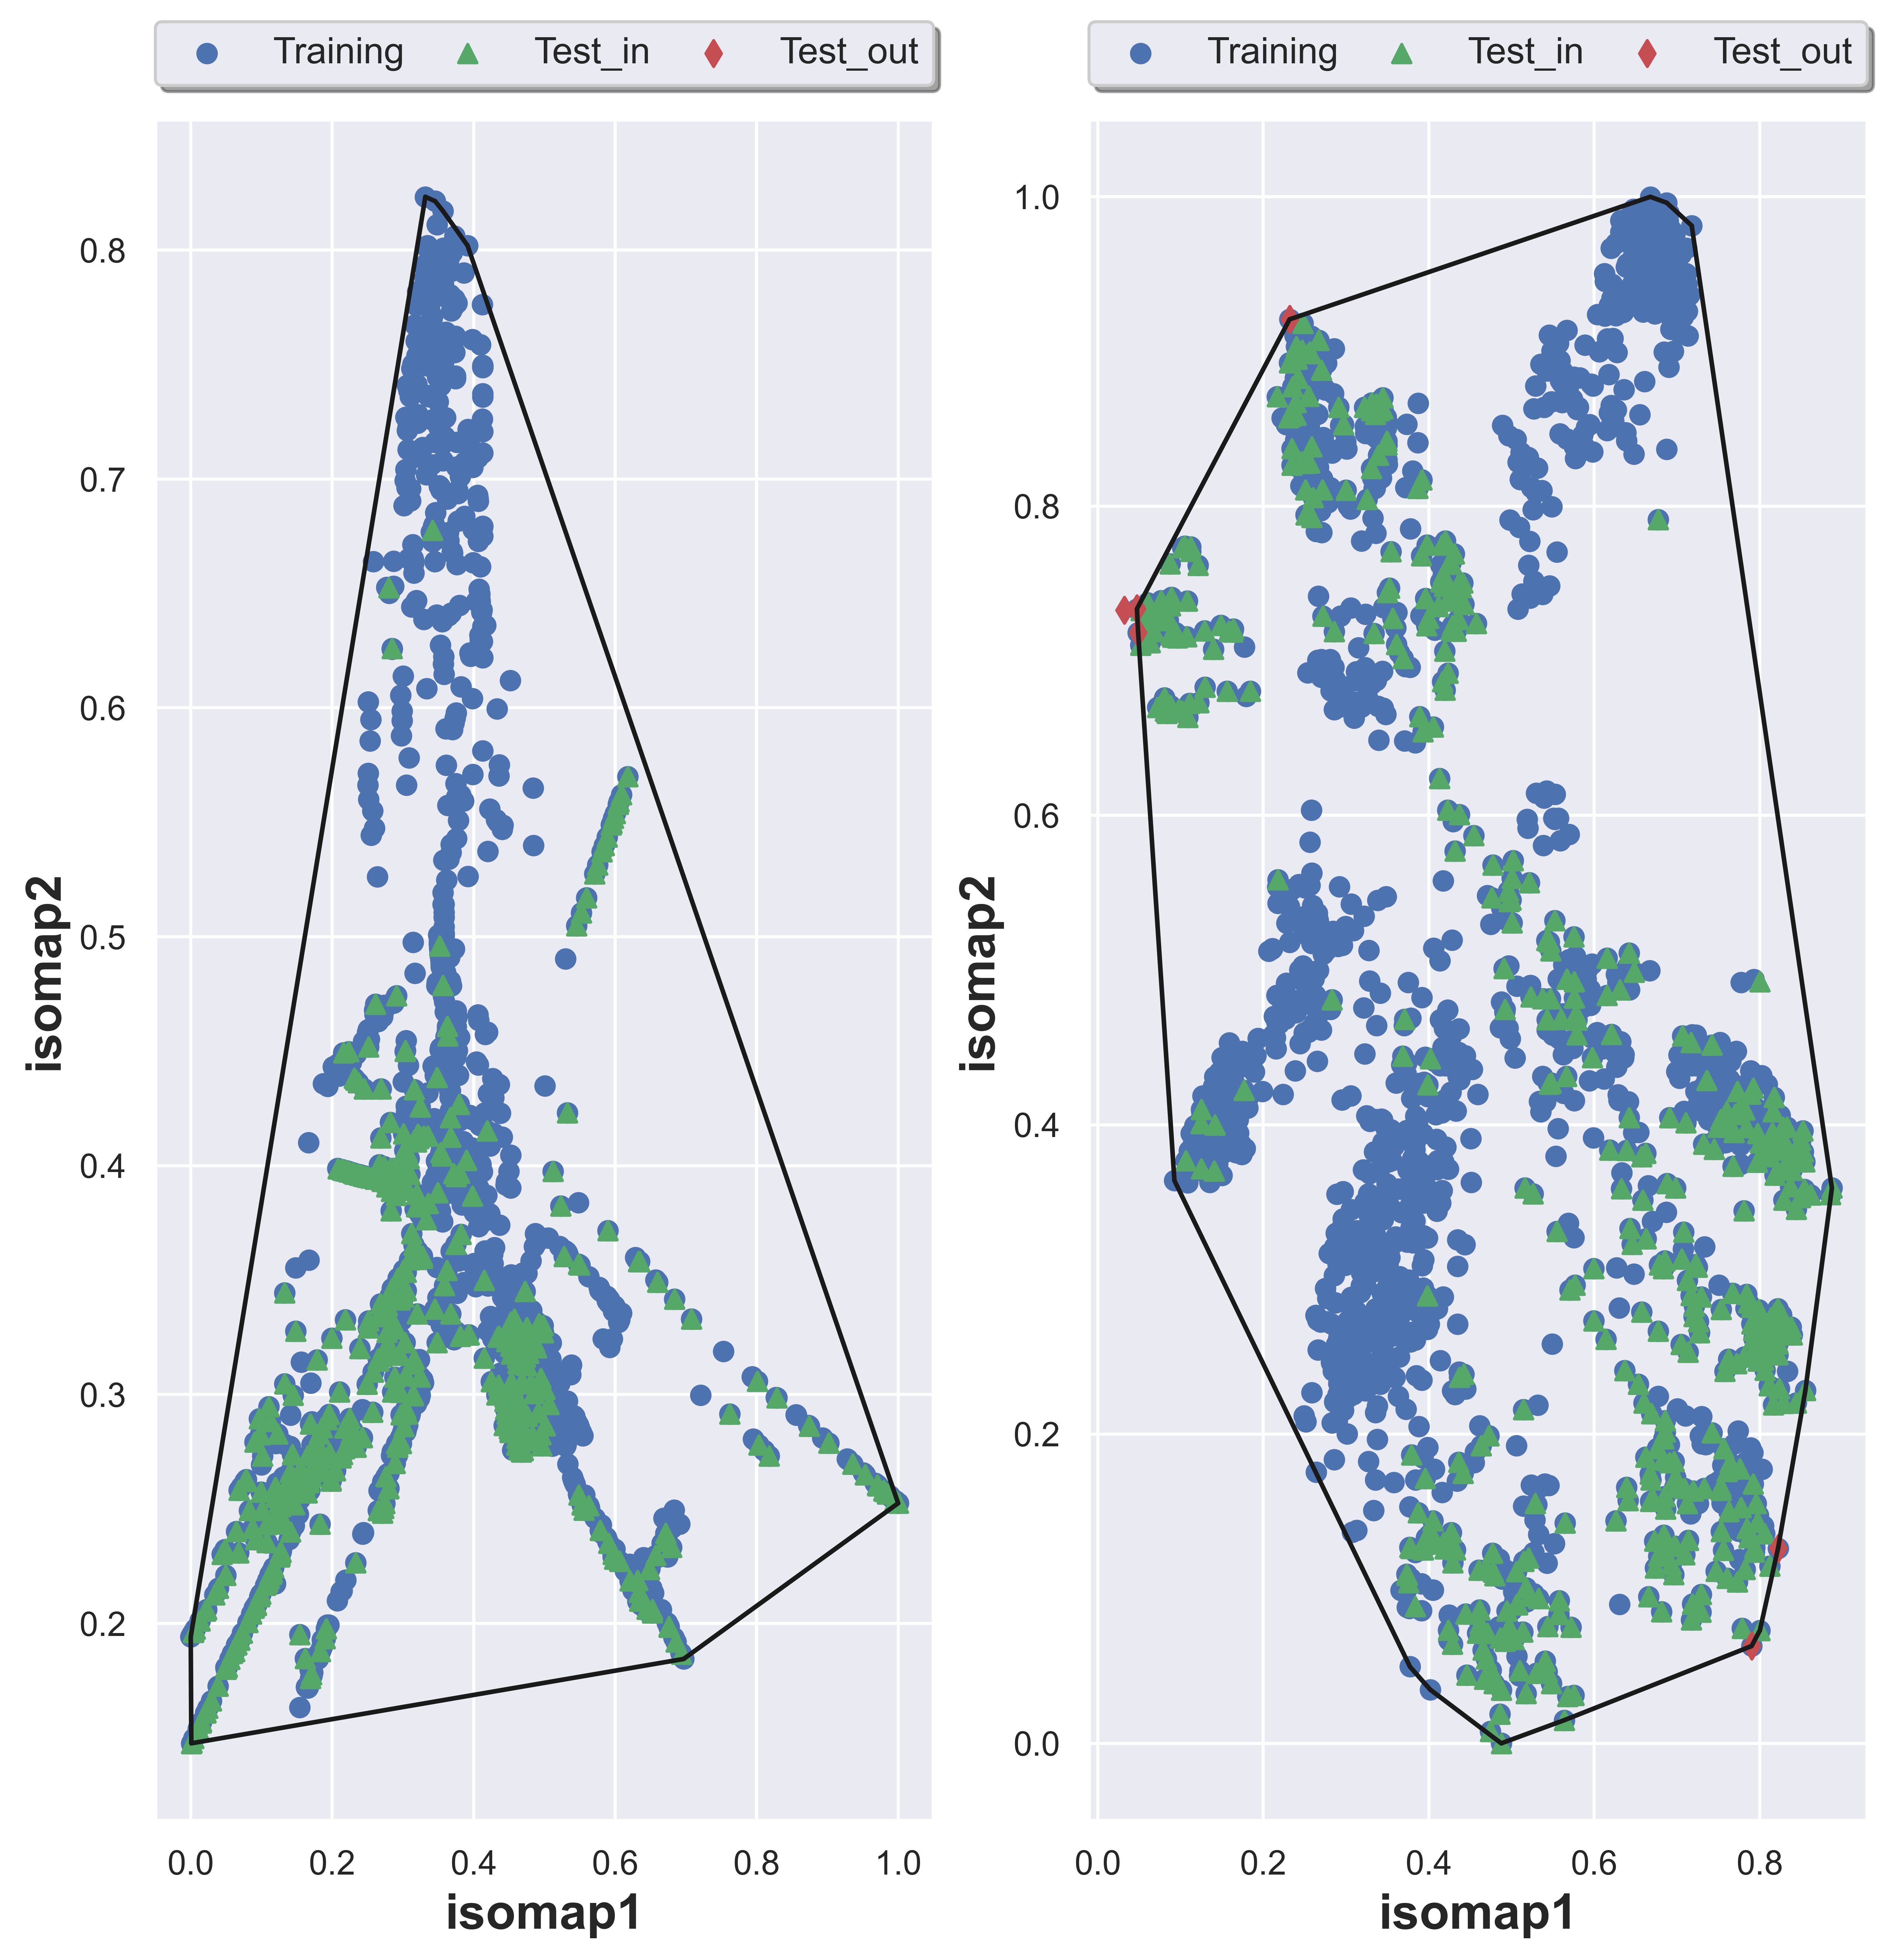

In [11]:
from similarity_convexhull import similarity_convexhull

cv =  similarity_convexhull(data =simi.matrix, list_training_fp= simi.list_training_fp,
                            list_test_fp =simi.list_test_fp, figsize=(10,10), save_fig=True)
cv.fit()

# **5. Filtering out molecules**

In [42]:
#Out molecules by second method
id_out = cv.index_out_mds

index_out = []
for key, value in enumerate(df_test_ad["ID"]):
    for id in id_out:
        if id == value:
            index_out.append(key)
            
df_test_ad.insert(2,"Applicability domain","In")
df_test_ad.loc[index_out,"Applicability domain"] = "Out"

In [50]:
df_out = df_test_ad[df_test_ad["Applicability domain"]== "Out"]
df_out

,ID,Molecule,Applicability domain,0,1,2,3,4,5,6,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
4,T5,<rdkit.Chem.rdchem.Mol object at 0x2bacdfd10>,Out,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,T275,<rdkit.Chem.rdchem.Mol object at 0x16a1e6570>,Out,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,T306,<rdkit.Chem.rdchem.Mol object at 0x16a1e5150>,Out,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,T413,<rdkit.Chem.rdchem.Mol object at 0x17494db60>,Out,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,T421,<rdkit.Chem.rdchem.Mol object at 0x17494dd20>,Out,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
468,T595,<rdkit.Chem.rdchem.Mol object at 0x174950dd0>,Out,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are 6 molecules that do not satisfy the applicability domain criteria.


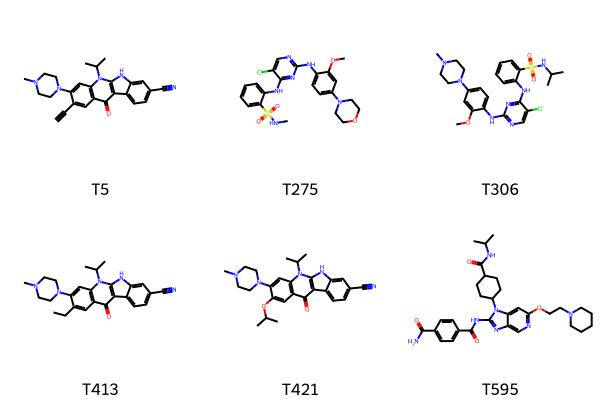

In [52]:
from rdkit.Chem import PandasTools
demo = df_out.rename(columns={'Molecule': 'ROMol'}, inplace=False)
print(f"There are {len(id_out)} molecules that do not satisfy the applicability domain criteria.")
PandasTools.FrameToGridImage(demo, legendsCol="ID", molsPerRow=3)